In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import numpy_ as np
import deepdish as dd
from brian2.only import *
import seaborn as sns

import spatial
import inputs

import conf.isi5_mouse as cfg
from demonstrator import demonstrator

In [2]:
res = dd.io.load(cfg.netfile.format(net=demonstrator['net']))
X, Y, W = res['X']*meter, res['Y']*meter, res['W']
stimulated_neurons = res['stimulated_neurons']
W[np.isnan(W)] = 0
Xstim, Ystim = spatial.create_stimulus_locations(cfg.params)

In [3]:
def get_distance_to_stim(stimid):
    Wb = W>0
    d = np.zeros_like(X, int)
    d[res['stimulated_neurons'][stimid]] = 1
    for i in range(2, 10):
        pre = (d == i-1) & (np.arange(len(d)) < cfg.params['N_exc'])
        post = np.unique(np.nonzero(Wb[pre])[1])
        added = False
        for p in post:
            if d[p] == 0:
                d[p] = i
                added = True
        if np.sum(d==0) == 0:
            dmax = i
            break
        elif not added:
            dmax = i-1
    d -= 1
    return d, dmax

In [4]:
dA, dA_max = get_distance_to_stim(cfg.stimuli['A'])
dB, dB_max = get_distance_to_stim(cfg.stimuli['B'])
dmax = max(dA_max, dB_max) - 1

In [5]:
_new_black = '#373737'
sns.set_theme(style='ticks', font_scale=0.75, rc={
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'DejaVu Sans'],
    'svg.fonttype': 'none',
    'text.usetex': False,
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'font.size': 8,
    'axes.labelsize': 8,
    'axes.titlesize': 9,
    'axes.labelpad': 2,
    'axes.linewidth': 0.5,
    'axes.titlepad': 4,
    'lines.linewidth': 0.5,
    'legend.fontsize': 8,
    'legend.title_fontsize': 9,
    'xtick.labelsize': 6,
    'ytick.labelsize': 6,
    'xtick.major.size': 2,
    'xtick.major.pad': 1,
    'xtick.major.width': 0.5,
    'ytick.major.size': 2,
    'ytick.major.pad': 1,
    'ytick.major.width': 0.5,
    'xtick.minor.size': 2,
    'xtick.minor.pad': 1,
    'xtick.minor.width': 0.5,
    'ytick.minor.size': 2,
    'ytick.minor.pad': 1,
    'ytick.minor.width': 0.5,

    # Avoid black unless necessary
    'text.color': _new_black,
    'patch.edgecolor': _new_black,
    'patch.force_edgecolor': False, # Seaborn turns on edgecolors for histograms by default and I don't like it
    'hatch.color': _new_black,
    'axes.edgecolor': _new_black,
    # 'axes.titlecolor': _new_black # should fallback to text.color
    'axes.labelcolor': _new_black,
    'xtick.color': _new_black,
    'ytick.color': _new_black
})

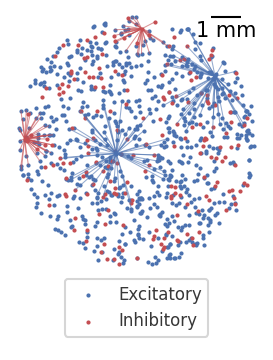

In [6]:
def plot_structure(ax):
    ax.scatter(X[:cfg.params['N_exc']], Y[:cfg.params['N_exc']], s=1, c='b', label='Excitatory')
    ax.scatter(X[cfg.params['N_exc']:], Y[cfg.params['N_exc']:], s=1, c='r', label='Inhibitory')
    for i in (0, 17):
        for j in np.flatnonzero(W[i]):
            ax.plot((X[i], X[j]), (Y[i], Y[j]), c='b', lw=.5, alpha=.6)
    for i in (903,908):
        for j in np.flatnonzero(W[i]):
            ax.plot((X[i], X[j]), (Y[i], Y[j]), c='r', lw=.5, alpha=.6)
    # ax.plot([], c='C9', label='Sample exc projections')
    # ax.plot([], c='C5', label='Sample inh projections')

    ax.add_artist(AnchoredSizeBar(ax.transData, 1*mm, '1 mm', 'upper right', frameon=False, borderpad=0))

    ax.legend(loc='lower center')

    ax.set_xticks([])
    ax.set_yticks([])
    sns.despine(ax=ax, left=True, bottom=True)

fig = plt.figure(figsize=(1.8, 2.2), dpi=150)
gs = fig.add_gridspec(1, 1, left=0, right=.9, top=1, bottom=0)
ax = fig.add_subplot(gs[0])
plot_structure(ax)
ax.set_ylim(-6.5*mm, 4.05*mm)
ax.set_xlim(-4.05*mm, 4.05*mm)
plt.savefig('fig1a.svg')

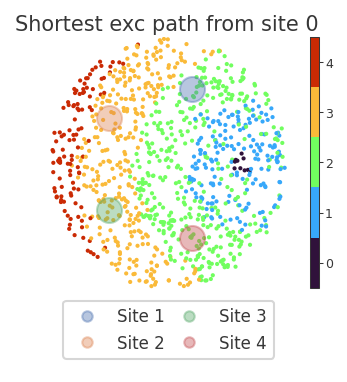

In [7]:
def plot_stim_structure(ax, cax):
    for coords in zip(Xstim[1:], Ystim[1:]):
        ax.plot(*coords, 'o', ms=12, alpha=.4)
    ax.set_prop_cycle(None)
    for label in range(1,5):
        ax.plot([], 'o', ms=5, alpha=.4, label=f'Site {label}')

    m = ax.scatter(X, Y, c=dA, s=1, cmap='turbo', vmax=dA_max-.5)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.legend(ncol=2, columnspacing=.5, loc='lower center')

    plt.colorbar(m, cax=cax, values=range(dA_max))
    cax.text(1, 1.01, 'Shortest exc path from site 0', transform=cax.transAxes, ha='right', va='bottom')
    sns.despine(ax=ax, left=True, bottom=True)

fig = plt.figure(figsize=(2,2.2), dpi=150)
gs = fig.add_gridspec(1, 1, left=0, right=.8, top=1, bottom=0)
ax = fig.add_subplot(gs[0])
cgs = fig.add_gridspec(1, 1, left=.87, right=.9, top=1, bottom=0.24)
cax = fig.add_subplot(cgs[0])
plot_stim_structure(ax, cax)
ax.set_xlim(-4.05*mm, 4.05*mm)
ax.set_ylim(-6.5*mm, 4.05*mm)
plt.savefig('fig1b.svg')